# Transfer Learning between MNIST and KMNIST using CNNs
  
## **Motivation:**  
- **MNIST vs. KMNIST:** Both datasets contain handwritten characters (digits in MNIST, Japanese characters in KMNIST) and share a similar structure.  
- **Transfer Learning:** We train a CNN on MNIST and then transfer (and finetune) the learned weights to KMNIST. We compare finetuning the entire network, freezing the convolutional layers, and training from scratch on KMNIST.

## **Architecture Design:**  
Our CNN is modularly built with a **FeatureExtractor** (two convolutional blocks) and a **ClassifierHead** (fully connected layer). This design facilitates transfer learning as it allows freezing the feature extractor while retraining only the classifier.

In [ ]:
# %% [code]
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import copy
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
# %% [code]
# Define transforms (normalize using MNIST statistics)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# MNIST Dataset
train_dataset_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Number of training examples in MNIST: {len(train_dataset_mnist)}")
print(f"Number of test examples in MNIST: {len(test_dataset_mnist)}")

# Split training set into training and validation
val_size = 5000
train_size = len(train_dataset_mnist) - val_size
train_dataset_mnist, val_dataset_mnist = random_split(train_dataset_mnist, [train_size, val_size])

train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=64, shuffle=True)
val_loader_mnist = DataLoader(val_dataset_mnist, batch_size=64, shuffle=False)
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=64, shuffle=False)

# KMNIST Dataset
train_dataset_kmnist = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_kmnist = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Split KMNIST training set into training and validation
train_size_k = len(train_dataset_kmnist) - val_size
train_dataset_kmnist, val_dataset_kmnist = random_split(train_dataset_kmnist, [train_size_k, val_size])

train_loader_kmnist = DataLoader(train_dataset_kmnist, batch_size=64, shuffle=True)
val_loader_kmnist = DataLoader(val_dataset_kmnist, batch_size=64, shuffle=False)
test_loader_kmnist = DataLoader(test_dataset_kmnist, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 36.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.84MB/s]


Number of training examples in MNIST: 60000
Number of test examples in MNIST: 10000


100%|██████████| 18.2M/18.2M [00:16<00:00, 1.08MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 3.04M/3.04M [00:02<00:00, 1.38MB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 4.22MB/s]


## Model Definition

The CNN is defined in a modular fashion:
- **FeatureExtractor:** Two convolutional blocks:
  - **Block 1:** Conv2D (32 filters, kernel=3, stride=1, padding=0) → ReLU → MaxPool2D (kernel=2)
  - **Block 2:** Conv2D (64 filters, kernel=3, stride=2, padding=1) → ReLU → MaxPool2D (kernel=2, stride=1)
  - **ClassifierHead:** Flattens the output (expected shape: 6×6×64) and applies a linear layer to obtain 10 class scores.


In [ ]:
# %% [code]
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),  # Output: (32, 26, 26)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),                           # Output: (32, 13, 13)
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Calculation: floor((13+2-3)/2)+1 = 7 → (64, 7, 7)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)                  # Output: (64, 6, 6)
        )
        print("Feature extractor summary:")
        print(self.features)

    def forward(self, x):
        return self.features(x)

class ClassifierHead(nn.Module):
    def __init__(self, in_features=6*6*64, num_classes=10):
        super(ClassifierHead, self).__init__()
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier_head = ClassifierHead()

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier_head(features)
        return logits


## Training & Evaluation

We define:
- A **training loop** with early stopping (patience = 3 epochs) based on the validation loss.
- An **evaluation loop** that computes the test loss, accuracy, and collects predictions for the confusion matrix.
- Utility functions to plot training curves and confusion matrices.


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())

        # Evaluate on validation set
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(dim=1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f} | Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break

    model.load_state_dict(best_model_wts)
    history = {'train_loss': train_losses, 'val_loss': val_losses, 'train_acc': train_accs, 'val_acc': val_accs}
    return model, history

def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    return test_loss, test_acc.item(), np.array(all_preds), np.array(all_labels)

def plot_training_curves(history, title_suffix=''):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12,5))
    # Loss Curve
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves ' + title_suffix)
    plt.legend()

    # Accuracy Curve
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves ' + title_suffix)
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


## Experiment 1: Train from Scratch on MNIST

We first train our CNN from scratch on MNIST. This will serve both as a baseline for MNIST performance and as a source of pre-trained weights for transfer learning.


Epoch 1/10 - Train loss: 0.4558, acc: 0.8560 | Val loss: 0.3238, acc: 0.8932
Epoch 2/10 - Train loss: 0.2983, acc: 0.9055 | Val loss: 0.2546, acc: 0.9188
Epoch 3/10 - Train loss: 0.2740, acc: 0.9141 | Val loss: 0.2839, acc: 0.9176
Epoch 4/10 - Train loss: 0.2655, acc: 0.9177 | Val loss: 0.2332, acc: 0.9324
Epoch 5/10 - Train loss: 0.2516, acc: 0.9226 | Val loss: 0.2679, acc: 0.9180
Epoch 6/10 - Train loss: 0.2485, acc: 0.9247 | Val loss: 0.2523, acc: 0.9234
Epoch 7/10 - Train loss: 0.2473, acc: 0.9235 | Val loss: 0.2370, acc: 0.9262
Early stopping triggered
MNIST Test Loss: 0.2184, Accuracy: 0.9375


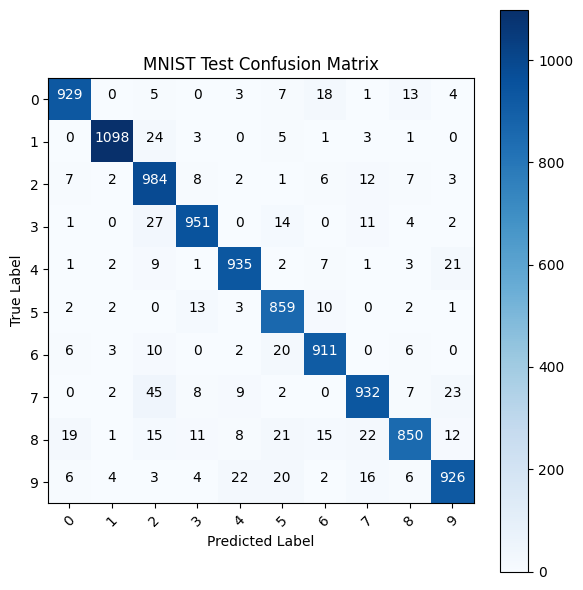

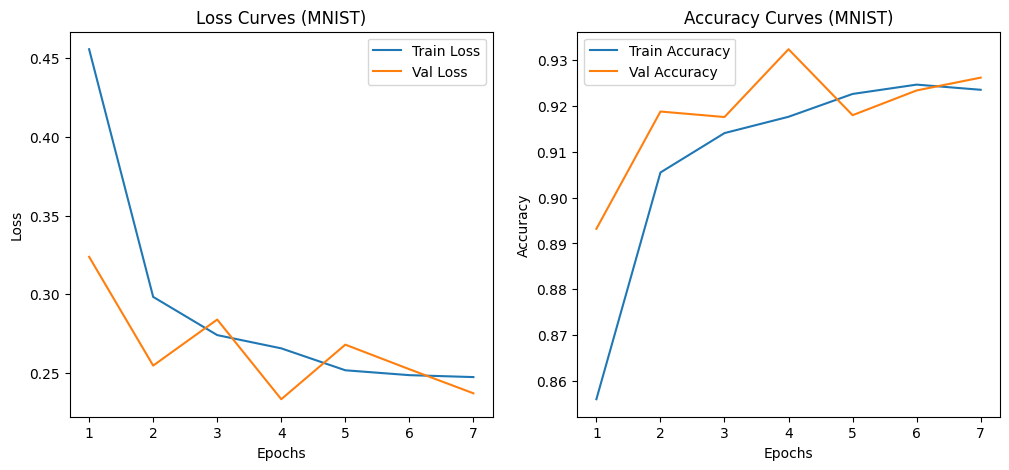

In [ ]:
# Initialize model, loss, and optimizer for MNIST
model_mnist = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mnist.parameters(), lr=0.01)

# Train on MNIST
model_mnist, history_mnist = train_model(model_mnist, train_loader_mnist, val_loader_mnist, criterion, optimizer, num_epochs=10, patience=3)

# Save the trained MNIST model
torch.save(model_mnist.state_dict(), 'model_mnist.pth')

# Evaluate on MNIST test set
test_loss_mnist, test_acc_mnist, preds_mnist, labels_mnist = evaluate_model(model_mnist, test_loader_mnist, criterion)
print(f"MNIST Test Loss: {test_loss_mnist:.4f}, Accuracy: {test_acc_mnist:.4f}")

# Plot confusion matrix for MNIST
cm_mnist = confusion_matrix(labels_mnist, preds_mnist)
plot_confusion_matrix(cm_mnist, classes=[str(i) for i in range(10)], title='MNIST Test Confusion Matrix')

# Plot training curves for MNIST
plot_training_curves(history_mnist, title_suffix='(MNIST)')

## Experiment 2: Finetune Full Model on KMNIST

Here, we load the pre-trained MNIST model and finetune the entire network on KMNIST. This demonstrates the effectiveness of transfer learning when adapting to a similar but distinct dataset.


Epoch 1/10 - Train loss: 0.8855, acc: 0.7345 | Val loss: 0.5178, acc: 0.8422
Epoch 2/10 - Train loss: 0.4856, acc: 0.8522 | Val loss: 0.4589, acc: 0.8550
Epoch 3/10 - Train loss: 0.4572, acc: 0.8587 | Val loss: 0.4501, acc: 0.8608
Epoch 4/10 - Train loss: 0.4481, acc: 0.8619 | Val loss: 0.4189, acc: 0.8712
Epoch 5/10 - Train loss: 0.4412, acc: 0.8638 | Val loss: 0.5001, acc: 0.8386
Epoch 6/10 - Train loss: 0.4402, acc: 0.8643 | Val loss: 0.4262, acc: 0.8670
Epoch 7/10 - Train loss: 0.4312, acc: 0.8672 | Val loss: 0.4484, acc: 0.8620
Early stopping triggered
KMNIST Finetuned Test Loss: 0.8890, Accuracy: 0.7426


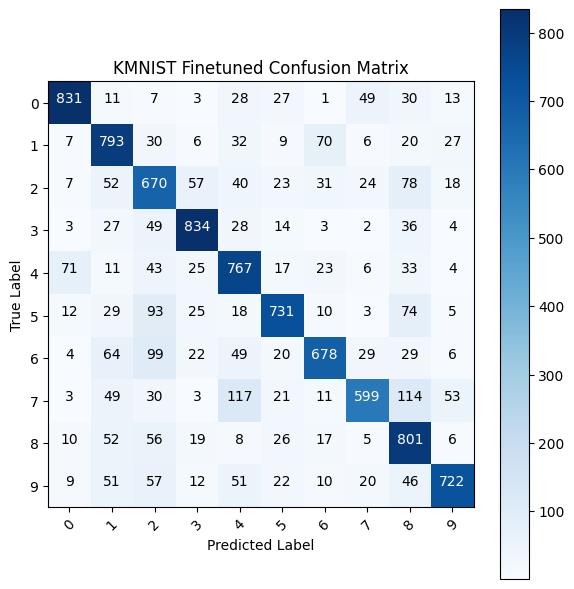

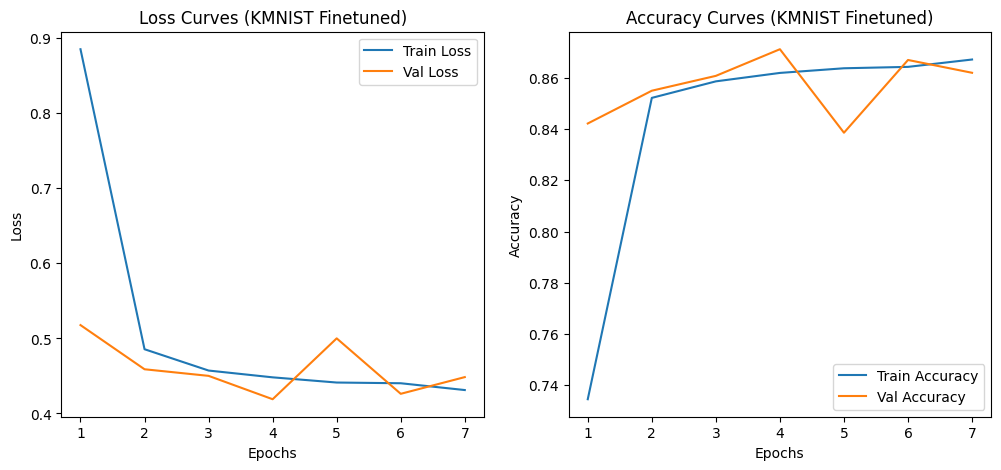

In [ ]:
# Initialize new model and load pre-trained weights from MNIST
model_finetune = CNN()
model_finetune.load_state_dict(torch.load('model_mnist.pth'))

# Set up optimizer for finetuning the entire model
optimizer_finetune = optim.Adam(model_finetune.parameters(), lr=0.01)

# Train (finetune) on KMNIST
model_finetune, history_finetune = train_model(model_finetune, train_loader_kmnist, val_loader_kmnist, criterion, optimizer_finetune, num_epochs=10, patience=3)

# Evaluate finetuned model on KMNIST test set
test_loss_finetune, test_acc_finetune, preds_finetune, labels_finetune = evaluate_model(model_finetune, test_loader_kmnist, criterion)
print(f"KMNIST Finetuned Test Loss: {test_loss_finetune:.4f}, Accuracy: {test_acc_finetune:.4f}")

# Plot confusion matrix for finetuned model
cm_finetune = confusion_matrix(labels_finetune, preds_finetune)
plot_confusion_matrix(cm_finetune, classes=[str(i) for i in range(10)], title='KMNIST Finetuned Confusion Matrix')

# Plot training curves for finetuning experiment
plot_training_curves(history_finetune, title_suffix='(KMNIST Finetuned)')

## Experiment 3: Freeze Convolutional Layers on KMNIST

In this experiment, we load the pre-trained MNIST model and freeze its feature extractor (convolutional layers). Only the classifier head is trained on KMNIST. This approach tests whether the learned features are generic enough for the new domain.


Epoch 1/10 - Train loss: 1.5658, acc: 0.5832 | Val loss: 1.1066, acc: 0.6554
Epoch 2/10 - Train loss: 1.1319, acc: 0.6532 | Val loss: 1.1186, acc: 0.6570
Epoch 3/10 - Train loss: 1.1192, acc: 0.6564 | Val loss: 1.0881, acc: 0.6770
Epoch 4/10 - Train loss: 1.1183, acc: 0.6568 | Val loss: 1.1168, acc: 0.6504
Epoch 5/10 - Train loss: 1.1168, acc: 0.6559 | Val loss: 1.0938, acc: 0.6564
Epoch 6/10 - Train loss: 1.1161, acc: 0.6563 | Val loss: 1.1242, acc: 0.6432
Early stopping triggered
KMNIST Frozen Conv Test Loss: 1.8341, Accuracy: 0.5048


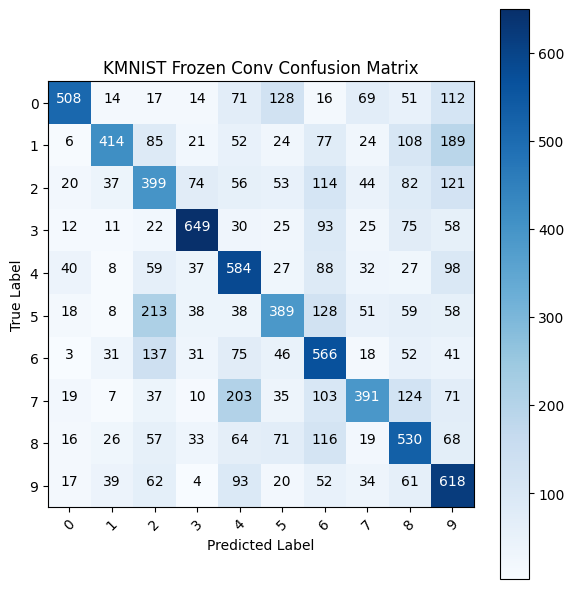

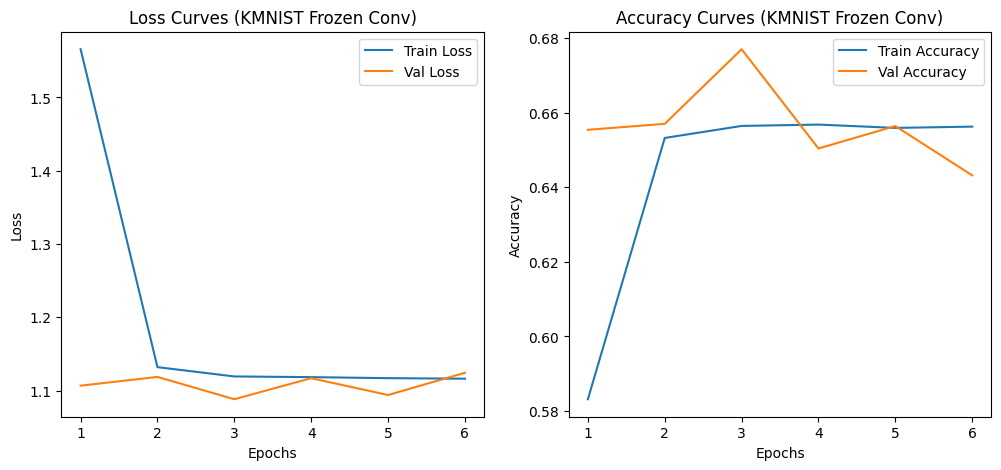

In [ ]:
# Initialize new model and load pre-trained MNIST weights
model_frozen = CNN()
model_frozen.load_state_dict(torch.load('model_mnist.pth'))

# Freeze the feature extractor layers
for param in model_frozen.feature_extractor.parameters():
    param.requires_grad = False

# Only parameters that require gradients (i.e. classifier head) are optimized
optimizer_frozen = optim.Adam(filter(lambda p: p.requires_grad, model_frozen.parameters()), lr=0.01)

# Train on KMNIST with frozen convolutional layers
model_frozen, history_frozen = train_model(model_frozen, train_loader_kmnist, val_loader_kmnist, criterion, optimizer_frozen, num_epochs=10, patience=3)

# Evaluate frozen model on KMNIST test set
test_loss_frozen, test_acc_frozen, preds_frozen, labels_frozen = evaluate_model(model_frozen, test_loader_kmnist, criterion)
print(f"KMNIST Frozen Conv Test Loss: {test_loss_frozen:.4f}, Accuracy: {test_acc_frozen:.4f}")

# Plot confusion matrix for frozen conv model
cm_frozen = confusion_matrix(labels_frozen, preds_frozen)
plot_confusion_matrix(cm_frozen, classes=[str(i) for i in range(10)], title='KMNIST Frozen Conv Confusion Matrix')

# Plot training curves for frozen conv experiment
plot_training_curves(history_frozen, title_suffix='(KMNIST Frozen Conv)')


## Experiment 4: Train from Scratch on KMNIST (Baseline)

As a baseline for KMNIST, we train the same CNN architecture from scratch on KMNIST.


Epoch 1/10 - Train loss: 2.3135, acc: 0.0995 | Val loss: 2.3043, acc: 0.0898
Epoch 2/10 - Train loss: 2.3034, acc: 0.0997 | Val loss: 2.3032, acc: 0.1076
Epoch 3/10 - Train loss: 2.3037, acc: 0.0975 | Val loss: 2.3036, acc: 0.0908
Epoch 4/10 - Train loss: 2.3037, acc: 0.0971 | Val loss: 2.3046, acc: 0.0996
Epoch 5/10 - Train loss: 2.3036, acc: 0.0993 | Val loss: 2.3039, acc: 0.1030
Early stopping triggered
KMNIST From Scratch Test Loss: 2.3036, Accuracy: 0.1000


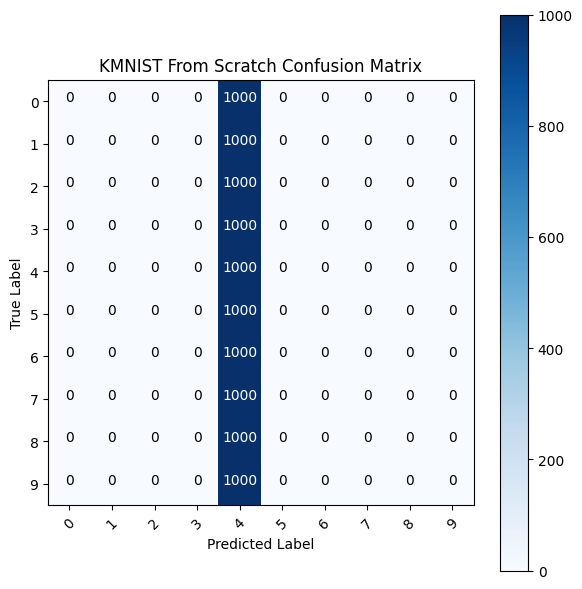

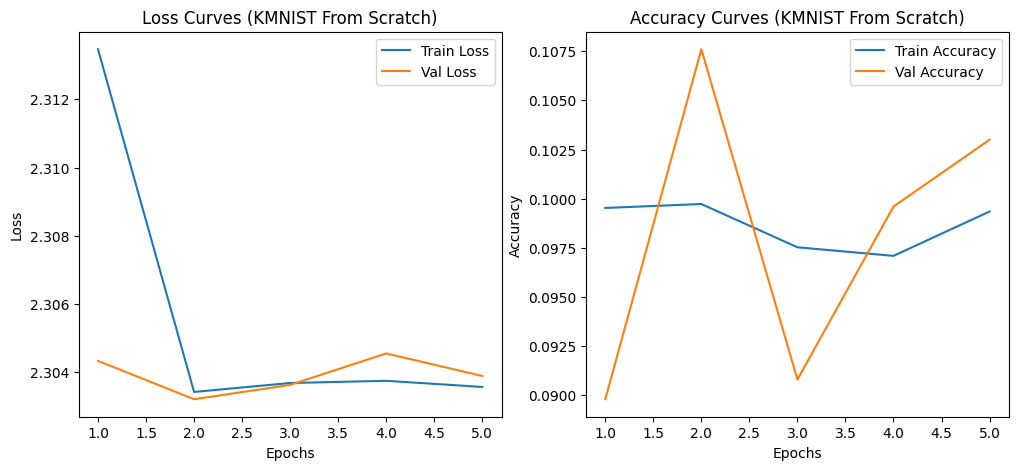

In [ ]:
# Initialize model for KMNIST baseline
model_kmnist = CNN()
optimizer_kmnist = optim.Adam(model_kmnist.parameters(), lr=0.01)

# Train from scratch on KMNIST
model_kmnist, history_kmnist = train_model(model_kmnist, train_loader_kmnist, val_loader_kmnist, criterion, optimizer_kmnist, num_epochs=10, patience=3)

# Evaluate baseline model on KMNIST test set
test_loss_kmnist, test_acc_kmnist, preds_kmnist, labels_kmnist = evaluate_model(model_kmnist, test_loader_kmnist, criterion)
print(f"KMNIST From Scratch Test Loss: {test_loss_kmnist:.4f}, Accuracy: {test_acc_kmnist:.4f}")

# Plot confusion matrix for baseline model
cm_kmnist = confusion_matrix(labels_kmnist, preds_kmnist)
plot_confusion_matrix(cm_kmnist, classes=[str(i) for i in range(10)], title='KMNIST From Scratch Confusion Matrix')

# Plot training curves for baseline experiment
plot_training_curves(history_kmnist, title_suffix='(KMNIST From Scratch)')

## Final Evaluation & Comparison

We now compare the test accuracies of the three KMNIST experiments:
- **Fully Finetuned Model** (Experiment 2)
- **Frozen Convolutional Layers** (Experiment 3)
- **From-Scratch Model** (Experiment 4)

In addition, we plot a bar chart to visually compare their performances.


Final Test Accuracies on KMNIST:
Finetuned Model: 0.7426
Frozen Conv Model: 0.5048
From Scratch Model: 0.1000


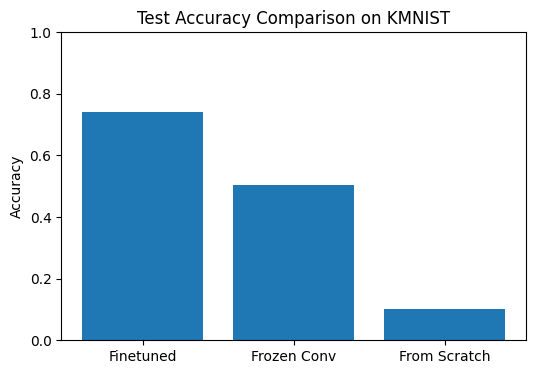

In [ ]:
print("Final Test Accuracies on KMNIST:")
print(f"Finetuned Model: {test_acc_finetune:.4f}")
print(f"Frozen Conv Model: {test_acc_frozen:.4f}")
print(f"From Scratch Model: {test_acc_kmnist:.4f}")

models = ['Finetuned', 'Frozen Conv', 'From Scratch']
accuracies = [test_acc_finetune, test_acc_frozen, test_acc_kmnist]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies)
plt.ylim(0,1)
plt.title('Test Accuracy Comparison on KMNIST')
plt.ylabel('Accuracy')
plt.show()

## Final Insights

- **Transfer Learning Benefit:**  
   The experiments demonstrate that initializing with MNIST weights can help the model learn faster or achieve higher accuracy on KMNIST due to similar image features.

- **Finetuning vs. Freezing:**  
   Finetuning the entire model allows all weights to adapt to the new dataset, while freezing the convolutional layers tests the generality of learned features. Compare the training curves and confusion matrices to understand the trade-offs.

- **Baseline Comparison:**  
   Training from scratch on KMNIST provides a baseline to assess the benefit of transfer learning.

Through these experiments, you can observe differences in convergence speed, final test accuracies, and misclassification patterns via confusion matrices.
